In [1]:
import numpy as np
from pathlib import Path
import pandas as pd
from sys import platform
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
if platform == "linux" or platform == "linux2":
    dir_folder = Path('/nrs/ahrens/Ziqiang/Takashi_DRN_project/ProcessedData/')
elif platform == 'win32':
    dir_folder = Path('U:\\Takashi') # put folder for windows system
dir_curr = Path('depreciated/spikes/')
vol_file = Path('depreciated/analysis_sections_based_on_swim_pattern.csv')
dat_xls_file = pd.read_csv(vol_file, index_col=0)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')

In [3]:
from utils import *
from scipy.signal import medfilt
from scipy.stats import sem, ranksums

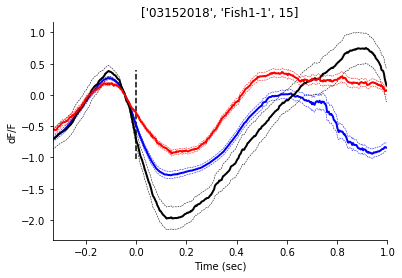

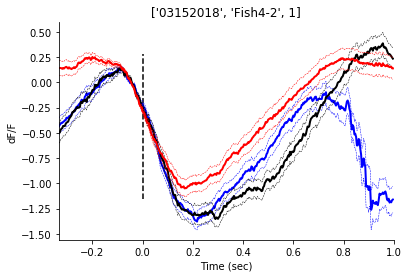

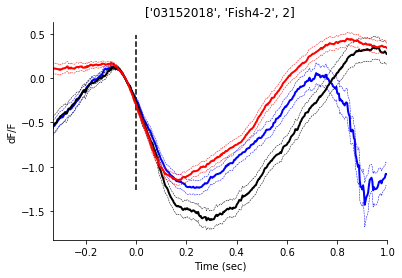

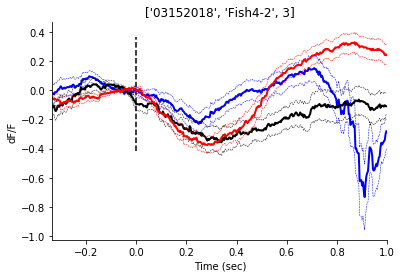

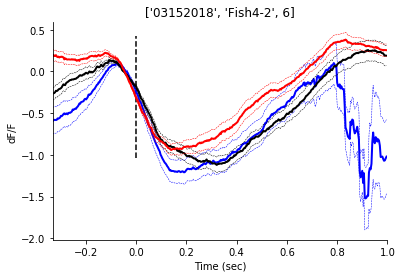

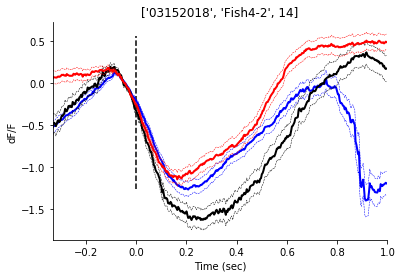

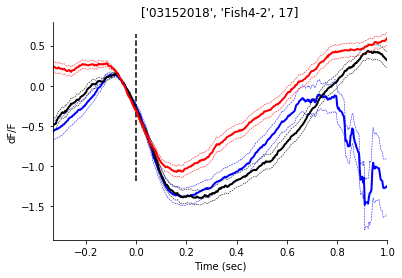

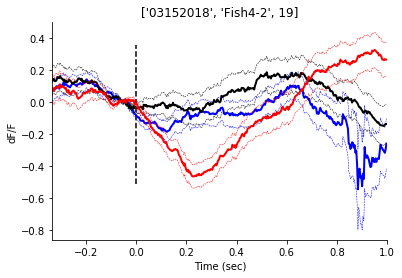

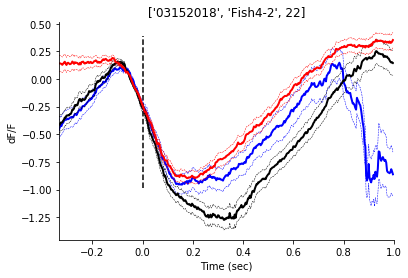

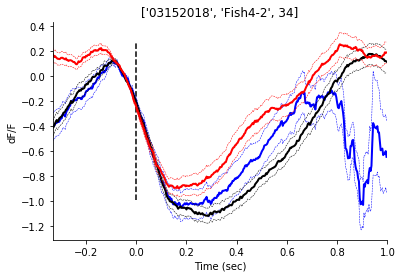

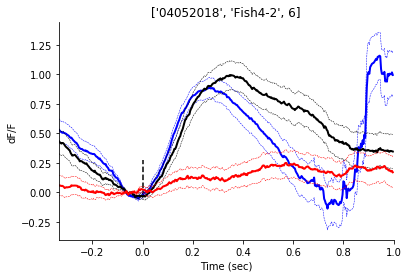

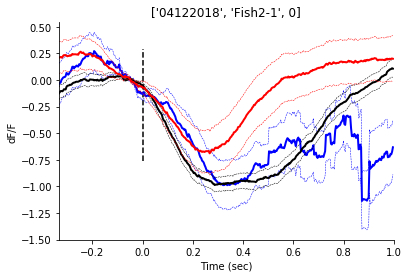

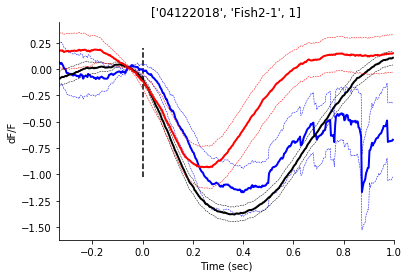

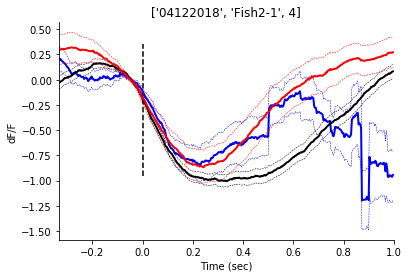

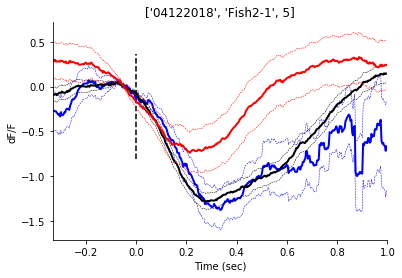

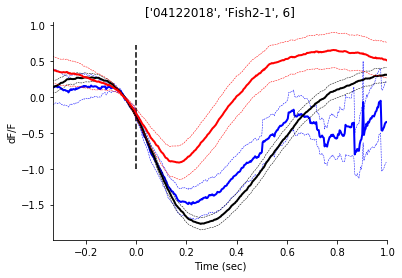

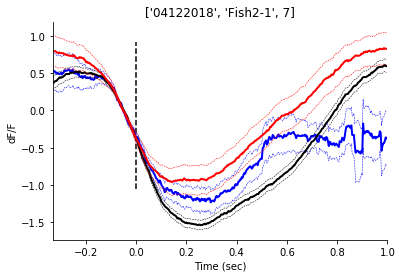

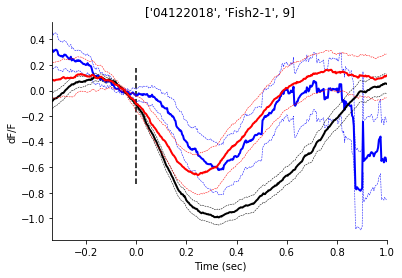

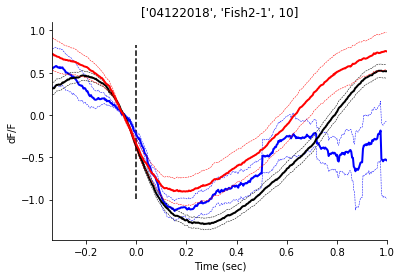

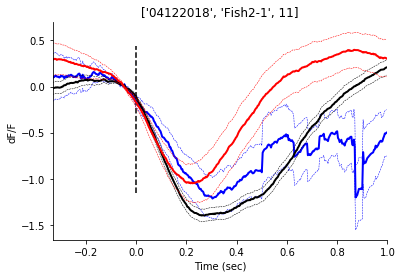

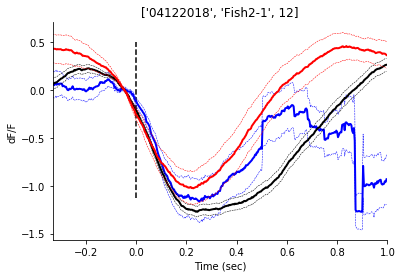

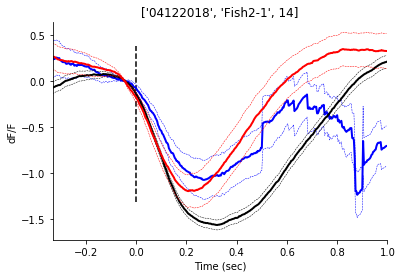

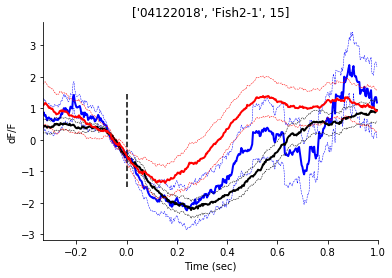

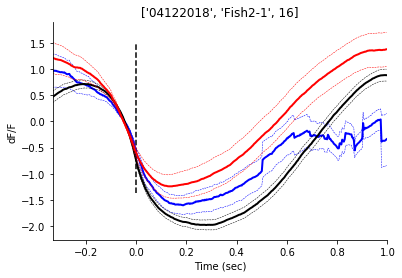

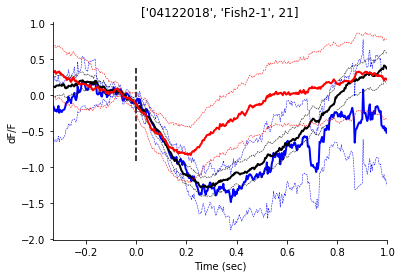

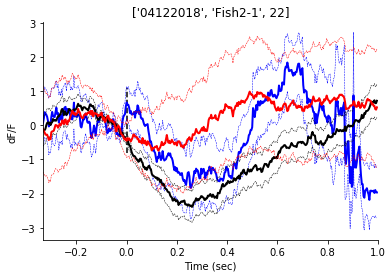

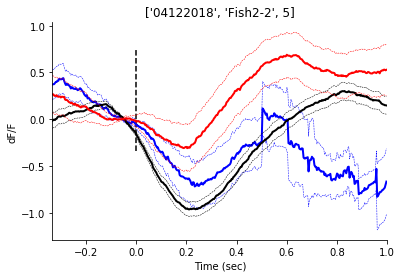

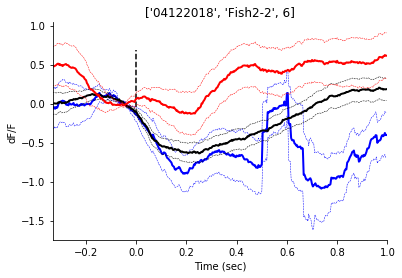

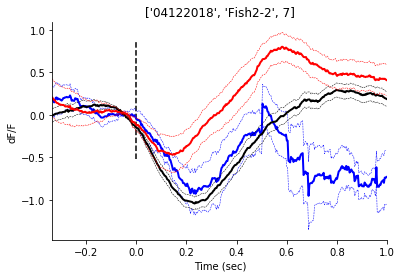

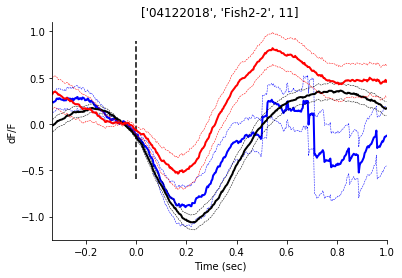

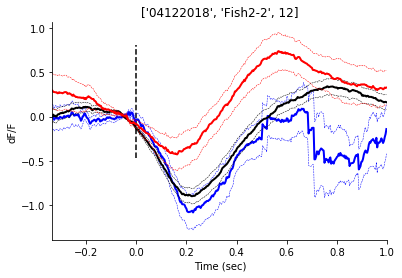

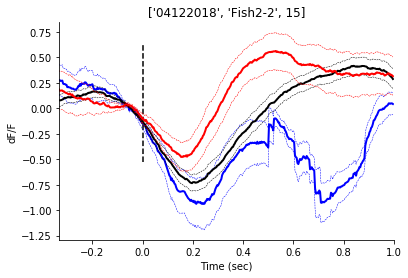

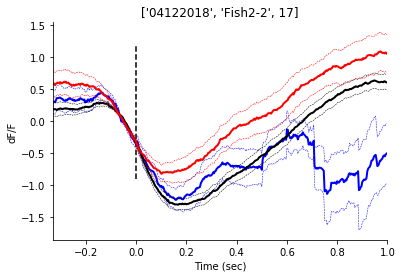

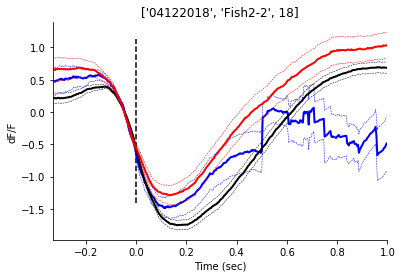

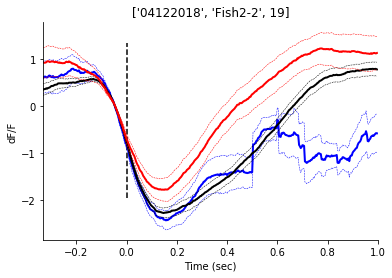

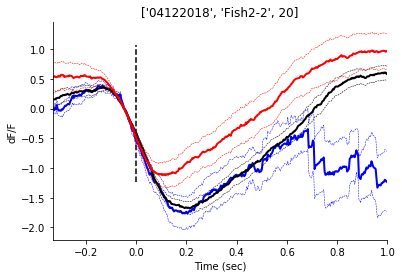

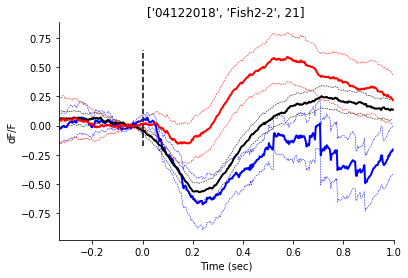

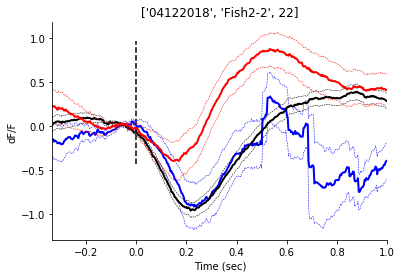

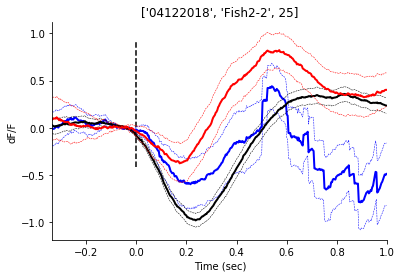

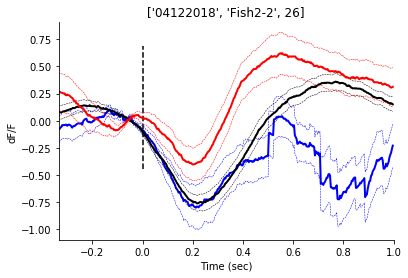

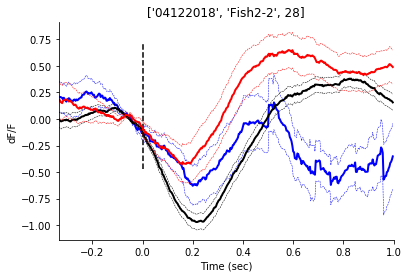

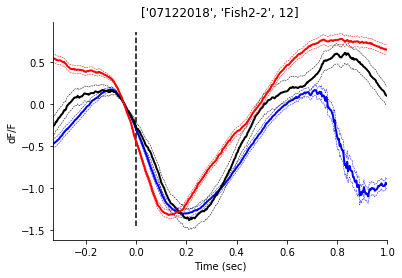

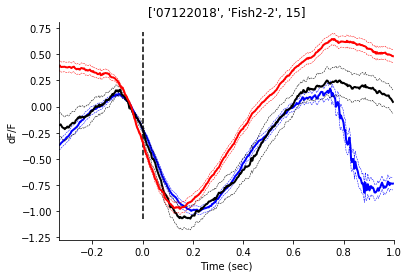

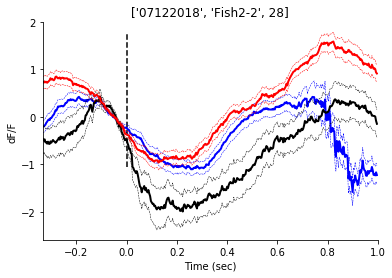

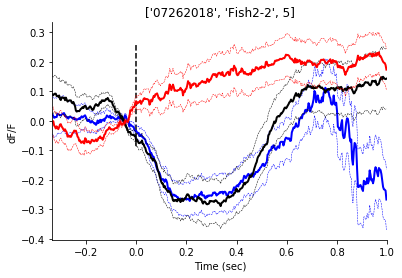

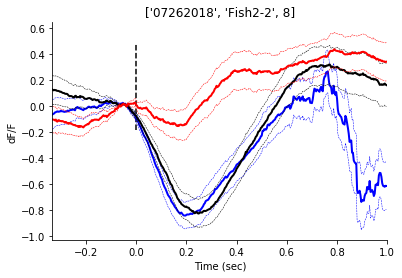

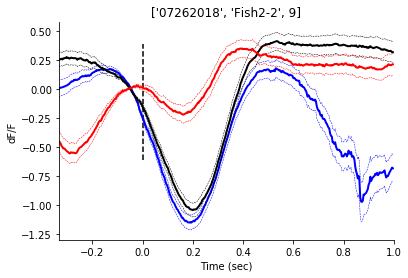

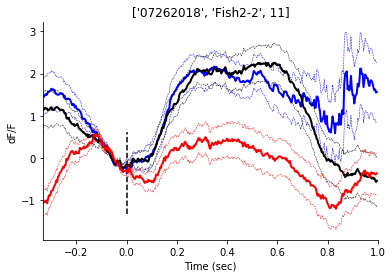

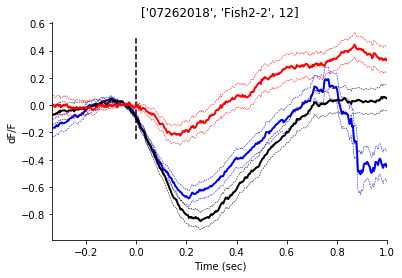

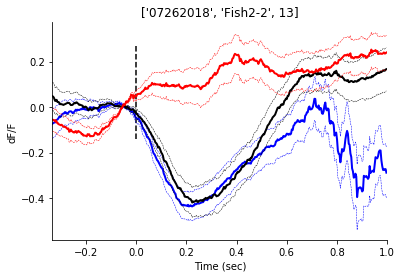

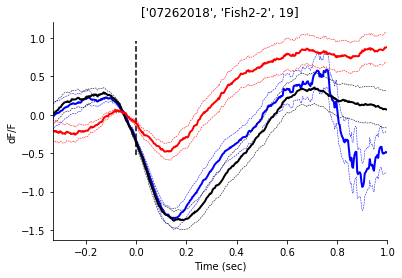

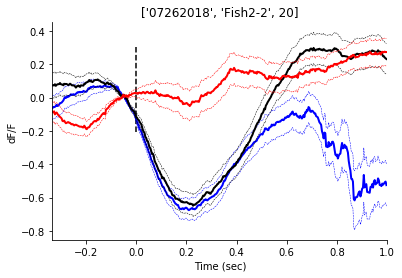

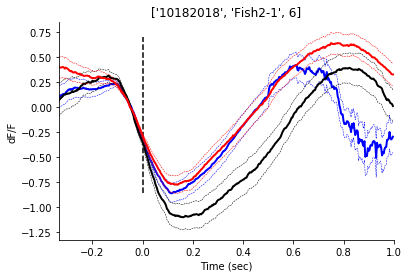

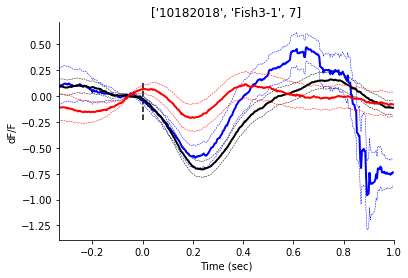

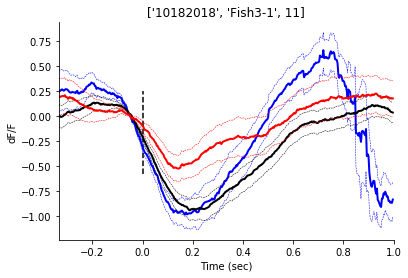

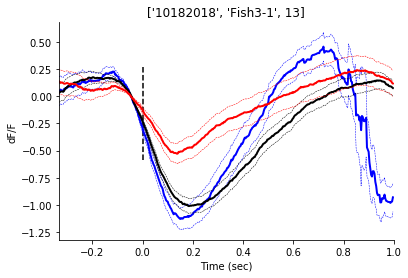

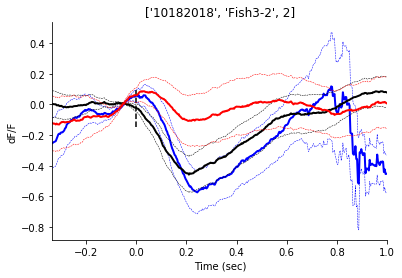

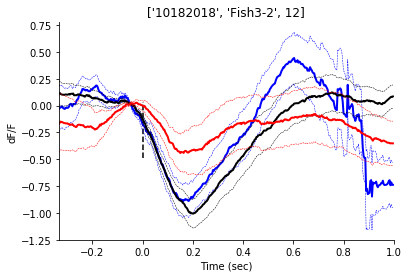

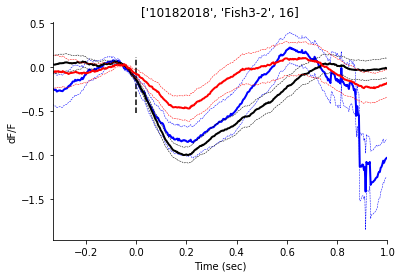

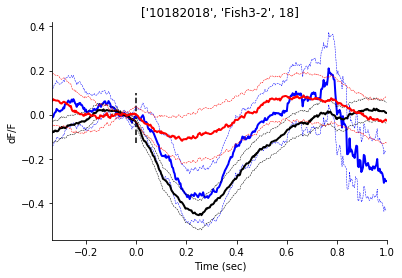

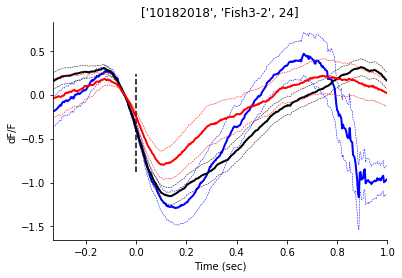

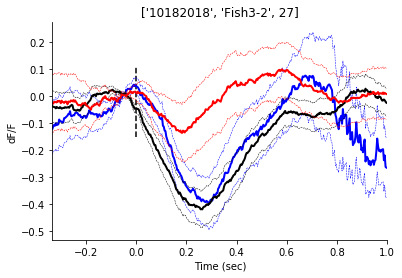

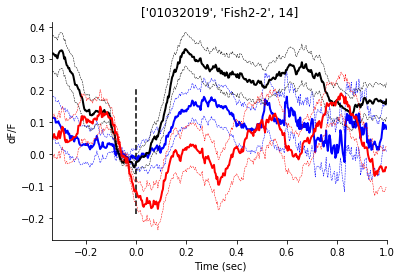

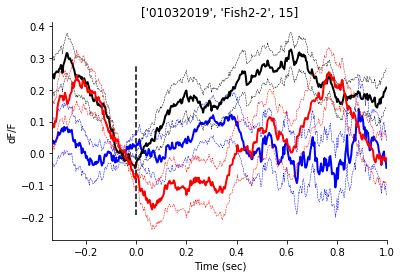

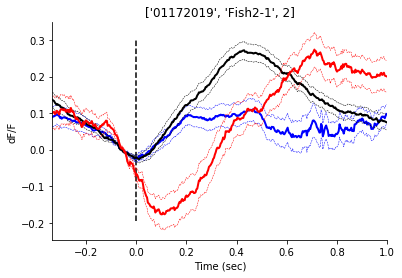

In [4]:
for _, row in dat_xls_file.iterrows():
    if 'Social' in row['task']:
        continue
    if 'Optovin' in row['task']:
        continue
    folder = row['folder']
    fish = row['fish']
    dat_dir = dir_folder/f'{folder}/{fish}/Data/'
    swim_dir = dir_folder/f'{folder}/{fish}/swim/'
    dff = np.load(dat_dir/'Voltr_spikes.npz')['voltrs']
    dff = dff - np.nanmedian(dff, axis=1, keepdims=True)
    spk = np.load(dat_dir/'Voltr_spikes.npz')['spk']
    num_cell = spk.shape[0]
    spk = np.r_['-1', np.zeros((num_cell, 600)), spk]
    frame_stimParams = np.load(swim_dir/'frame_stimParams.npy')
    frame_swim_tcourse = np.load(swim_dir/'frame_swim_tcourse.npy')

    _ = np.load(f'swim_power/{folder}_{fish}_swim_dat.npz')
    swim_starts = _['swim_starts']
    swim_ends = _['swim_ends']
    r_swim = _['r_swim']
    l_swim = _['l_swim']
    visu = _['visu']
    task_period = _['task_period']
    swim_task_index = _['swim_task_index']
    p_swim = np.sqrt(r_swim**2+l_swim**2)

    n_task = task_period.max().astype('int')
    swim_task_index_ = (swim_task_index-1)%n_task+1
    swim_bout_index_task = np.zeros(len(swim_task_index_)).astype('int')
    swim_bout_index_task[0] = 1
    for n_bout in range(len(swim_task_index_)-1):
        if swim_task_index_[n_bout] == swim_task_index_[n_bout-1]:
            swim_bout_index_task[n_bout] = swim_bout_index_task[n_bout-1]+1
        else:
            swim_bout_index_task[n_bout] = 1

    swim_bout_index_task = swim_bout_index_task
    
    subvolt = dff.copy()
    k_filter = 30
    for n_cell, ndff in enumerate(dff):
        if spk[n_cell].sum()<100:
            continue
        subvolt[n_cell, :] = medfilt(ndff, kernel_size=k_filter*2+1)
        sub_list = np.zeros((r_swim.shape[0], 400))
        sub_list[:] = np.nan
        trial_valid_ = np.ones(r_swim.shape[0]).astype('bool')
        for n, n_swim in enumerate(swim_starts):
            if (n_swim>100) and (n_swim+300<len(subvolt[n_cell])):
                sub_list[n, :] = subvolt[n_cell, n_swim-100:n_swim+300] 
                sub_list[n, :] = sub_list[n, :] - sub_list[n, 70:100].mean()
                late_swim = np.where(p_swim[n]>0)[0]
                if (late_swim>200).sum()>0:
                    late_swim = late_swim[late_swim>200]
                    sub_list[n, late_swim+50] = np.nan
                    trial_valid_[n] = False
            else:
                trial_valid_[n] = False

        t_min = 0
        t_max = 400
        ave_ = sub_list[task_period==1, :]*100
        if (np.isnan(ave_).sum(axis=-1)==0).sum()<20:
            continue
        ave_low = ave_[np.isnan(ave_).sum(axis=-1)==0, :]
        ave_ = sub_list[task_period==2, :]*100
        ave_high = ave_[np.isnan(ave_).sum(axis=-1)==0, :]
        
        n_p = np.zeros(400)
        for _ in range(400):
            __, n_p[_] = ranksums(ave_low[:, _], ave_high[:, _])
        
        if (n_p[100:]<0.05).mean()<0.4:
            continue
            
        ave_ = sub_list[task_period==1, :]*100
        ave_ = ave_[(np.isnan(ave_).sum(axis=-1)<90) & (np.isnan(ave_).sum(axis=-1)>30), :]
        mean_ = np.nanmean(ave_[:, t_min:t_max], axis=0)
        max_ = mean_.max()
        min_ = mean_.min()
        std_ = sem(ave_[:, t_min:t_max], axis=0, nan_policy='omit')
        plt.plot(np.arange(t_max-t_min)/300-(100-t_min)/300, mean_, '-b', lw=2)
        plt.plot(np.arange(t_max-t_min)/300-(100-t_min)/300, mean_-std_, '--b', lw=0.5)
        plt.plot(np.arange(t_max-t_min)/300-(100-t_min)/300, mean_+std_, '--b', lw=0.5)
        
        mean_ = np.nanmean(ave_low[:, t_min:t_max], axis=0)
        max_ = mean_.max()
        min_ = mean_.min()
        std_ = sem(ave_low[:, t_min:t_max], axis=0, nan_policy='omit')
        plt.plot(np.arange(t_max-t_min)/300-(100-t_min)/300, mean_, '-k', lw=2)
        plt.plot(np.arange(t_max-t_min)/300-(100-t_min)/300, mean_-std_, '--k', lw=0.5)
        plt.plot(np.arange(t_max-t_min)/300-(100-t_min)/300, mean_+std_, '--k', lw=0.5)

        mean_ = np.nanmean(ave_high[:, t_min:t_max], axis=0)
        # mean_ = mean_ - mean_[70:(100-t_min)].mean()
        max_ = mean_.max()
        min_ = mean_.min()
        std_ = np.nanstd(ave_high[:, t_min:t_max], axis=0)/np.sqrt(ave_.shape[0])
        plt.plot(np.arange(t_max-t_min)/300-(100-t_min)/300, mean_, '-r', lw=2)
        plt.plot(np.arange(t_max-t_min)/300-(100-t_min)/300, mean_-std_, '--r', lw=0.5)
        plt.plot(np.arange(t_max-t_min)/300-(100-t_min)/300, mean_+std_, '--r', lw=0.5)

        # plt.ylim([0, 2.2])
        plt.xlim([-(100-t_min)/300, (t_max-100)/300])
        plt.vlines([0], [min_-np.abs(min_)*0.1], [max_+np.abs(max_)*0.1], colors='k', linestyles='--')
        plt.xlabel('Time (sec)')
        plt.ylabel('dF/F')
        sns.despine()
        plt.title([folder, fish, n_cell])
        plt.show()
        
        spk_list = np.zeros((r_swim.shape[0], 400))
        for n, n_swim in enumerate(swim_starts):
            if (n_swim>100) and (n_swim+300<len(subvolt[n_cell])):
                spk_list[n, :] = spk[n_cell, n_swim-100:n_swim+300]         
        k_ = boxcarKernel(sigma=60)
        ave_ = []
        for n_spk in spk_list[(task_period==1) & trial_valid_, :]*300:
            ave_.append(smooth(n_spk, k_))
        ave_ = np.array(ave_)
        mean_ = ave_[:, 50:350].mean(axis=0)
        std_ = ave_[:, 50:350].std(axis=0)/np.sqrt(ave_.shape[0])
        plt.plot(np.arange(300)/300-50/300, mean_, '-k', lw=2)
        plt.plot(np.arange(300)/300-50/300, mean_-std_, '--k', lw=0.5)
        plt.plot(np.arange(300)/300-50/300, mean_+std_, '--k', lw=0.5)
        ave_ = []
        for n_spk in spk_list[(task_period==2) & trial_valid_, :]*300:
            ave_.append(smooth(n_spk, k_))
        ave_ = np.array(ave_)
        mean_ = ave_[:, 50:350].mean(axis=0)
        std_ = ave_[:, 50:350].std(axis=0)/np.sqrt(ave_.shape[0])
        plt.plot(np.arange(300)/300-50/300, mean_, '-r', lw=2)
        plt.plot(np.arange(300)/300-50/300, mean_-std_, '--r', lw=0.5)
        plt.plot(np.arange(300)/300-50/300, mean_+std_, '--r', lw=0.5)
        plt.ylim([0, 2.2])
        plt.xlim([-50/300, 250/300])
        plt.vlines([0], [0], [2.2], colors='k', linestyles='--')
        plt.xlabel('Time (sec)')
        plt.ylabel('Spikes (/sec)')
        sns.despine()
        plt.plot()       
        plt.title([folder, fish, n_cell])
        plt.show()